# Exploratory Data Analysis: Risk Analytics

This notebook aims to validate the quality and coherence of the synthetic dataset generated for the fraud detection project. Before training any model, we must confirm that behavioral patterns (fixed expenses, seasonality, customer profiles) and fraud patterns (velocity and magnitude attacks) are correctly reflected in the data. 

## 1. Configuration and Data Loading

We import necessary libraries and load the `transactions_simulated.csv` dataset, making sure each column is interpreted as the correct dtype.  

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

file_path = os.path.join("..","data", "transactions_simulated.csv")
df = pd.read_csv(file_path, 
                 dtype={'Customer_Profile': 'category', 
                        'Location': 'category', 
                        'Category': 'category',
                        'Is_Fraud': 'int8',
                        'Is_Fixed': 'int8'},
                 parse_dates=['Timestamp'])

# Add an additional column to classify transactions between Legitimate, Magnitude attacks and Velocity attacks.
df['TXN_Type'] = df.apply(
    (lambda x: 'Velocity' if 'VEL' in x['Terminal_ID'] and x['Is_Fraud'] == 1 
               else 'Magnitude' if 'BIG' in x['Terminal_ID'] and x['Is_Fraud'] == 1
               else 'Legitimate'), axis=1)
df['TXN_Type'] = df['TXN_Type'].astype('category')

print(df.head())

  Transaction_ID Customer_ID Customer_Profile Customer_Home  Amount  \
0      FRD-36877    CUS-0697          Unknown        Malaga   11.36   
1      FRD-38579    CUS-0859          Unknown     Barcelona    7.55   
2      FRD-38580    CUS-0859          Unknown     Barcelona   22.26   
3      FRD-36878    CUS-0697          Unknown        Malaga    5.94   
4      FRD-38581    CUS-0859          Unknown     Barcelona   11.06   

            Timestamp   Terminal_ID Category  Location  Is_Fixed  Is_Fraud  \
0 2026-01-01 02:03:00  TERM_VEL_055   Retail    Malaga         0         1   
1 2026-01-01 02:03:00  TERM_VEL_383   Retail  Zaragoza         0         1   
2 2026-01-01 02:04:00  TERM_VEL_383   Retail  Zaragoza         0         1   
3 2026-01-01 02:04:00  TERM_VEL_055   Retail    Malaga         0         1   
4 2026-01-01 02:05:00  TERM_VEL_383   Retail  Zaragoza         0         1   

   TXN_Type  
0  Velocity  
1  Velocity  
2  Velocity  
3  Velocity  
4  Velocity  


We have all the columns we wanted. The content seems correct.

In [76]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39229 entries, 0 to 39228
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction_ID    39229 non-null  object        
 1   Customer_ID       39229 non-null  object        
 2   Customer_Profile  39229 non-null  category      
 3   Customer_Home     39229 non-null  object        
 4   Amount            39229 non-null  float64       
 5   Timestamp         39229 non-null  datetime64[ns]
 6   Terminal_ID       39229 non-null  object        
 7   Category          39229 non-null  category      
 8   Location          39229 non-null  category      
 9   Is_Fixed          39229 non-null  int8          
 10  Is_Fraud          39229 non-null  int8          
 11  TXN_Type          39229 non-null  category      
dtypes: category(4), datetime64[ns](1), float64(1), int8(2), object(4)
memory usage: 2.0+ MB
None


Theres no null entries in any column and the dtypes are correct.

## 2. Fraud Analysis

In fraud detection, we expect a strong class imbalance. Most transactions are legitimate. We verify the fraud ratio to confirm it is within a realistic range. If it were very high (>5%) or very low (<0.01%), we would face issues training the model later.


In [77]:
fraud_counts = df['Is_Fraud'].value_counts()
fraud_rate_tx = (df['Is_Fraud'].mean()) * 100
    
print(f"Global Fraud Ratio (By Transaction): {fraud_rate_tx:.2f}%")
print(f"Total Fraud Transactions: {df['Is_Fraud'].sum()}")

Global Fraud Ratio (By Transaction): 6.68%
Total Fraud Transactions: 2621


The reason theres 2621 fraud cases is beacause each individual operation of the velocity attacks counts as one. In reality, we should have the 500 anomalies if grouped correctly.

In [78]:
fraud_counts = df[df['Is_Fraud'] == 1].nunique()['Terminal_ID']
fraud_rate = fraud_counts / (df.shape[0] - 2121 ) * 100 # Adjusted rate taking into account velocity attacks as one transaction

print(f"Global Fraud Ratio (By Transaction): {fraud_rate:.2f}%")
print(f"Total Frauds: {fraud_counts}")

Global Fraud Ratio (By Transaction): 1.35%
Total Frauds: 500


A bit less than 1.5% due to the generation of fixed expenses being independent from discretionary ones.

### Attack Typology

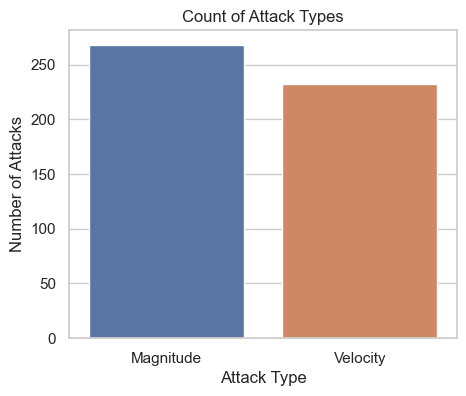

In [79]:
# Visual style configuration for plots
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

# Create a collapsed dataframe for fraud analysis, each attack is grouped into a single row
attacks_collapsed = df[df['Is_Fraud'] == 1].groupby('Terminal_ID').agg(
        Attack_Type=('TXN_Type', 'first'),      # 0 if it is a velocity attack, 1 if it is a magnitude attack
        Total_Attempts=('Transaction_ID', 'count'),       
        Total_Stolen=('Amount', 'sum'),                   
        Start_Time=('Timestamp', 'min'),                 
        End_Time=('Timestamp', 'max'),               
        Victim_ID=('Customer_ID', 'first')       
    ).reset_index()
attacks_collapsed['Attack_Type'] = attacks_collapsed['Attack_Type'].cat.remove_categories(['Legitimate'])

# Plotting the distribution of attack types
fig, ax_count = plt.subplots(figsize=(5, 4))
sns.countplot(x='Attack_Type', data=attacks_collapsed, ax = ax_count, hue='Attack_Type')
ax_count.set_title('Count of Attack Types')
ax_count.set_ylabel('Number of Attacks')
ax_count.set_xlabel('Attack Type')

plt.show()

We observe a roughly equal split between Velocity and Magnitude fraud cases, preventing bias toward a single attack type.

### Attack Timing

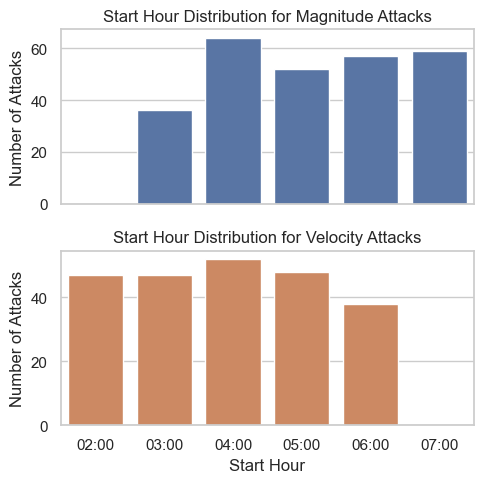

In [80]:
# Plotting the distribution of start hours for each attack type
attacks_collapsed['Start_Hour'] = attacks_collapsed['Start_Time'].dt.hour          # Feature engineering for start hour

h_order = [h for h in range(2,8)]                   # Hours from 1 to 8 AM to create the x-axis labels
h_label = [f"{h:02d}:00" for h in h_order]

# Plotting the distribution of hours for magnitude attack
fig, (ax_hmag , ax_hvel) = plt.subplots(2,1, figsize=(5, 5), sharex=True)
sns.countplot(x = attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Magnitude']['Start_Hour'], ax=ax_hmag, order=h_order, color='#4c72b0')
ax_hmag.set_title('Start Hour Distribution for Magnitude Attacks')
ax_hmag.set_xlabel('Start Hour')
ax_hmag.set_ylabel('Number of Attacks')

# Plotting the distribution of hours for velocity attack
sns.countplot(x = attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Velocity']['Start_Hour'],  ax=ax_hvel, order=h_order, color='#dd8452')
ax_hvel.set_title('Start Hour Distribution for Velocity Attacks')
ax_hvel.set_xlabel('Start Hour')
ax_hvel.set_xticks(range(len(h_order)))
ax_hvel.set_xticklabels(h_label)
ax_hvel.set_ylabel('Number of Attacks')
plt.tight_layout()

plt.show()

Fraud occurs exclusively during low-traffic hours (02:00 – 07:00):

- Magnitude Attacks: 03:00 AM – 07:00 AM with a uniform distribution.
- Velocity Attacks: 02:00 AM – 06:00 AM with a uniform distribution.

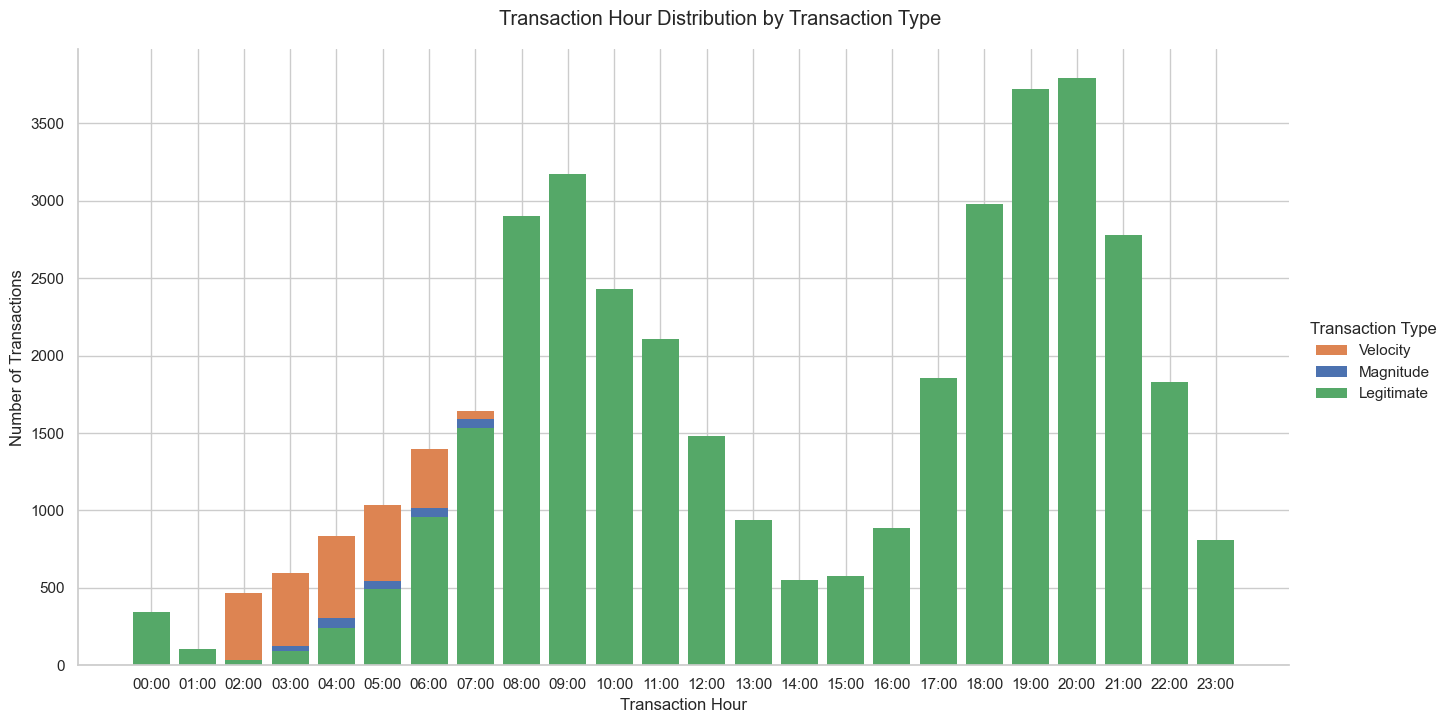

In [81]:
# Plotting the distribution of transaction hour for non-fraud transactions stacked with fraud transactions
df['Hour'] = df['Timestamp'].dt.hour           # Feature engineering for transaction hour

g = sns.displot(
        data=df,
        x='Hour',
        hue='TXN_Type',
        multiple='stack',
        palette={'Legitimate': '#55a868', 'Velocity': '#dd8452', 'Magnitude': '#4c72b0'},
        hue_order=['Velocity', 'Magnitude', 'Legitimate'],
        discrete=True, shrink=0.8, height=7, aspect=1.9, alpha=1.0, linewidth=0      
    )

g.set_axis_labels('Transaction Hour', 'Number of Transactions')
g.fig.suptitle('Transaction Hour Distribution by Transaction Type', y=1.03)
g.set(xticks=range(0, 24))
g.ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24)])
g.legend.set_title('Transaction Type')

plt.show()

The stacked histogram above provides a critical validation of our simulation engine's temporal logic:

1. Bimodal Distribution:

    The Legitimate (Green) transactions  clearly exhibit the intended double-peak structure, reflecting real-world human activity.

    - Morning Peak (~10:00 AM): Corresponds to daily commutes and opening business hours.
    - Evening Peak (~08:00 PM): Corresponds to leisure activities and after-work shopping.
    - Night Valley: Activity drops significantly during sleeping hours (23:00 - 06:00 AM), creating a natural low-volume window.

2. Fraud Isolation:

    While legitimate traffic follows a bimodal distribution, Velocity (Orange) and Magnitude (Blue) fraud attempts are distinctly concentrated in the low-volume overnight window. This visual separation confirms that our anomaly injection logic successfully targeted the "vulnerable hours" where anomalies stand out against the background noise.

### Day of the week

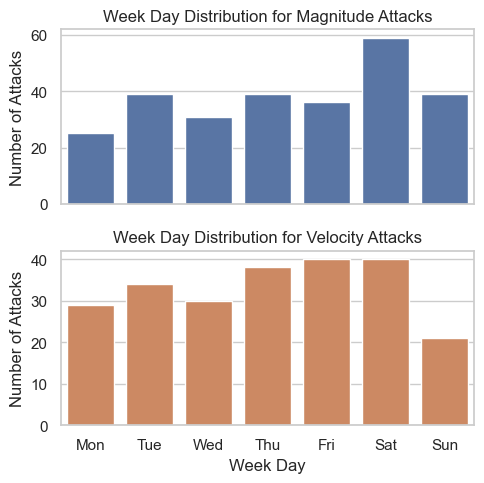

In [82]:
# Plotting the distribution of week days for each attack type
attacks_collapsed['Week_Day'] = attacks_collapsed['Start_Time'].dt.day_name()     # Feature engineering for week day of the attack

w_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  # Week day order for x-axis
w_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig, (ax_wmag , ax_wvel) = plt.subplots(2,1, figsize=(5, 5), sharex=True)

# Plotting the distribution of week days for magnitude attack
sns.countplot(x = attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Magnitude']['Week_Day'], ax=ax_wmag, order=w_order, color='#4c72b0')
ax_wmag.set_title('Week Day Distribution for Magnitude Attacks')
ax_wmag.set_xlabel('Week Day')
ax_wmag.set_ylabel('Number of Attacks')

# Plotting the distribution of week days for velocity attack
sns.countplot(x = attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Velocity']['Week_Day'],  ax=ax_wvel, order=w_order, color='#dd8452')
ax_wvel.set_title('Week Day Distribution for Velocity Attacks')
ax_wvel.set_xlabel('Week Day')
ax_wvel.set_xticks(range(len(w_label)))
ax_wvel.set_xticklabels(w_label)
ax_wvel.set_ylabel('Number of Attacks')
plt.tight_layout()

plt.show()

Fraudulent transactions (both Velocity and Magnitude) exhibit uniform-like distribution across the week. Maybe Magnitude attacks happen more often on Saturdays and Velocity attacks are less likely to happen on Sundays. Next up we will test the statistical significance of this affirmation.

In [83]:
from scipy.stats import chisquare

def test_uniformity(df, column_name):
    """
    Performs a Chi-Squared test to verify uniformity in a categorical column.
    """
    print(f'Uniformity Test (Chi-Squared) for: {column_name}')
    
    observed_counts = df[column_name].value_counts().sort_index()
    
    total_events = observed_counts.sum()
    n_categories = len(observed_counts)
    expected_count = total_events / n_categories

    expected_counts = [expected_count] * n_categories

    chi2_stat, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts)
    
    print(f'Chi2 Statistic: {chi2_stat:.4f}')
    print(f'P-Value: {p_value:.4f}')
    
    alpha = 0.05
    if p_value < alpha:
        print('Result: Null hypothesis rejected.')
        print(f'Conclusion: The distribution of {column_name} is NOT uniform (There is seasonality/patterns).')
    else:
        print('Result: Cannot reject the null hypothesis.')
        print(f'Conclusion: The distribution of {column_name} is compatible with being UNIFORM.')

# Testing uniformity for 'Week_Day' column
print("\nTesting Uniformity for Magnitude Attacks:")
test_uniformity(attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Magnitude'], 'Week_Day')

print("\nTesting Uniformity for Velocity Attacks:")
test_uniformity(attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Velocity'], 'Week_Day')


Testing Uniformity for Magnitude Attacks:
Uniformity Test (Chi-Squared) for: Week_Day
Chi2 Statistic: 17.3806
P-Value: 0.0080
Result: Null hypothesis rejected.
Conclusion: The distribution of Week_Day is NOT uniform (There is seasonality/patterns).

Testing Uniformity for Velocity Attacks:
Uniformity Test (Chi-Squared) for: Week_Day
Chi2 Statistic: 8.8362
P-Value: 0.1830
Result: Cannot reject the null hypothesis.
Conclusion: The distribution of Week_Day is compatible with being UNIFORM.


Unexpectedly, the Chi-Squared test for Magnitude Fraud rejected the null hypothesis of uniformity ($p < 0.05$), despite the generation logic using a uniform random selection.

This phenomenon is likely due to sample size volatility. Since Magnitude Fraud has a bit over 250 transactions registered, Type I Error or simply lack of convergence odds are higher and this result is possible.

On the other hand, Velocity attacks passed the test, confirming a statistically uniform distribution across the days of the week. This lack of seasonality may serve as a feature for our ML models.

If we were analyzing this dataset as an external Data Scientist without prior knowledge of the generation script, these statistical tests would have leaded me to the following insights regarding fraud patterns.

1.  Detecting Automation via Uniformity:
    The fact that Velocity Fraud passed the Chi-Squared test for uniformity ($p > 0.05$) would be my primary indicator of bot activity. In a real-world investigation, observing a high-frequency transaction pattern that completely ignores weekly human cycles (weekends, workdays) is a strong indicator of automated scripts.

2.  Profiling "Campaigns" via Seasonality:
    Conversely, the rejection of uniformity in Magnitude Fraud ($p < 0.05$) would lead me to classify these events as seasonal. In cybersecurity, high-value attacks are rarely constant, they occur in bursts when a vulnerability is exploited.

It is crucial to interpret these results with transparency. While the insights derived from the statistical tests make perfect sense from an analytical perspective, classifying Velocity attacks as "bots" and Magnitude attacks as "campaigns", we possess the ground truth of the generation logic and these insights are the result of a statistical coincidence.

This observation serves as a powerful reminder for Risk Analysts. While statistical tests are essential tools for inference, they can sometimes over-interpret noise as a signal, especially when analyzing rare events (minority classes). In a real-world scenario without access to the "source code", we might have incorrectly concluded that there was an intentional temporal pattern where there was only chance.

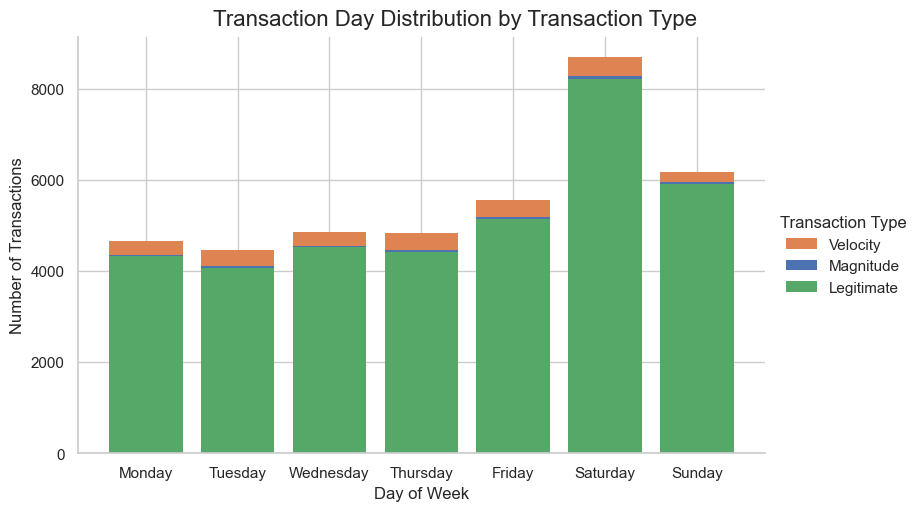

In [84]:
# Plotting the distribution of transaction hour for non-fraud transactions stacked with fraud transactions
df['Week_Day'] = df['Timestamp'].dt.day_name()       # Feature engineering for transaction week day
df['Week_Day'] = pd.Categorical(df['Week_Day'], categories=w_order, ordered=True)

g = sns.displot(
        data=df,
        x='Week_Day',
        hue='TXN_Type',
        multiple='stack',
        palette={'Legitimate': '#55a868', 'Velocity': '#dd8452', 'Magnitude': '#4c72b0'},
        hue_order=['Velocity', 'Magnitude', 'Legitimate'],
        discrete=True, shrink=0.8, height=5, aspect=1.6, alpha=1.0, linewidth=0
    )

g.set_axis_labels('Day of Week', 'Number of Transactions')
g.fig.suptitle('Transaction Day Distribution by Transaction Type', y=1.02, fontsize=16)
    
g.legend.set_title('Transaction Type')

plt.show()

The distribution of transactions across the days of the week further validates our behavioral simulation, the volume of legitimate transactions remains relatively uniform during weekdays (Monday to Thursday), reflecting routine daily spending.

A significant surge occurs on Friday and weekends, with activity peaking on Saturday and remaining high on Sunday. This aligns with the increased weights assigned to discretionary categories like Leisure and Retail during free time.

Given the previous coincidence in the chisquare test, we will perform it on the non-fraudulent transactions.

In [85]:
# Testing uniformity for 'Week_Day' column for legitimate transactions

print("\nTesting Uniformity for Legitimate transactions:")
test_uniformity(df[df['TXN_Type'] == 'Legitimate'], 'Week_Day')


Testing Uniformity for Legitimate transactions:
Uniformity Test (Chi-Squared) for: Week_Day
Chi2 Statistic: 2431.8150
P-Value: 0.0000
Result: Null hypothesis rejected.
Conclusion: The distribution of Week_Day is NOT uniform (There is seasonality/patterns).


In [86]:
print(sns.color_palette("deep").as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']
